## Does `EnergyModel` actually work for estimation?

The notebook runs a load of automated tests and gets the `EnergyModel` estimation of energy usage, then compares it with the values from energy.json.

In [1]:
from env import TestEnv
import pandas as pd
import json
import os
from conf import LisaLogging
from bart.common.Utils import area_under_curve
from trappy.plotter import plot_trace
from IPython.display import display
from trappy import ILinePlot
from trappy.stats.grammar import Parser
import pandas as pd

LisaLogging.setup()
import logging
logging.getLogger('Trace').setLevel(logging.ERROR)
logging.getLogger('Analysis').setLevel(logging.WARNING)
%matplotlib inline

2017-01-11 14:53:18,753 INFO    : root         : Using LISA logging configuration:
2017-01-11 14:53:18,754 INFO    : root         :   /home/brejac01/sources/lisa/logging.conf


In [2]:
import tests.eas.generic
from tests.eas.generic import EnergyModelTest

## Run all the tests
This will probalby take ages

In [3]:
# Disable drawing power from USB
# !adb -s GA0113TP0180 shell "echo 'echo 0 > /sys/class/power_supply/battery/charging_enabled' | su"

In [4]:
scs = EnergyModelTest.__subclasses__()

In [5]:
tests = []
all_experiments = []
measured_energy = []
est_energy = []

for cls in scs[0:1]:
    cls.setUpClass()
    if not cls.te.emeter:
        raise Exception("This notebook won't work without an energy meter configured")
    t = cls()
    tests.append(t)
    for exp in t.executor.experiments:
        all_experiments.append(exp)
        json_path = os.path.join(exp.out_dir, "energy.json")
        with open(json_path) as f:
            energy = json.load(f)
        energy = sum(energy.values())
        measured_energy.append(energy)
                
        est_power = t.get_power_df(t.executor.experiments[0])['power']
        est_energy.append(area_under_curve(est_power))

2017-01-11 14:53:18,825 INFO    : LisaTest     : Setup tests execution engine...
2017-01-11 14:53:18,826 INFO    : TestEnv      : Using base path: /home/brejac01/sources/lisa
2017-01-11 14:53:18,827 INFO    : TestEnv      : Loading default (file) target configuration
2017-01-11 14:53:18,827 INFO    : TestEnv      : Loading target configuration [/home/brejac01/sources/lisa/target.config]...
2017-01-11 14:53:18,830 INFO    : TestEnv      : Loading custom (inline) test configuration
2017-01-11 14:53:18,831 INFO    : TestEnv      : Devlib modules to load: ['bl', u'cpuidle', 'cgroups', 'hwmon', 'cpufreq']
2017-01-11 14:53:18,831 INFO    : TestEnv      : Connecting linux target:
2017-01-11 14:53:18,832 INFO    : TestEnv      :   username : brendan
2017-01-11 14:53:18,833 INFO    : TestEnv      :       host : 192.168.2.2
2017-01-11 14:53:18,834 INFO    : TestEnv      :   password : password
2017-01-11 14:53:18,835 INFO    : TestEnv      : Connection settings:
2017-01-11 14:53:18,835 INFO    :

2017-01-11 14:54:14,833 INFO    : Workload     : Workload execution START:
2017-01-11 14:54:14,835 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/one_small_00.json 2>&1
2017-01-11 14:54:24,255 INFO    : Executor     : Collected FTrace binary trace:
2017-01-11 14:54:24,257 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:one_small/1/trace.dat
2017-01-11 14:54:24,259 INFO    : Executor     : Collected FTrace function profiling:
2017-01-11 14:54:24,260 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:one_small/1/trace_stat.json
2017-01-11 14:54:24,262 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-11 14:54:24,264 INFO    : Executor     : 
2017-01-11 14:54:24,266 INFO    : Executor     : ################################################################################
2017-01-11 14:54:24,267 INFO    : Executor     : Experiments execution completed
2017-0

Maximum estimated system energy: 1725
Maximum estimated system energy: 1725


# Compare `EnergyModel` estimation with measured value

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


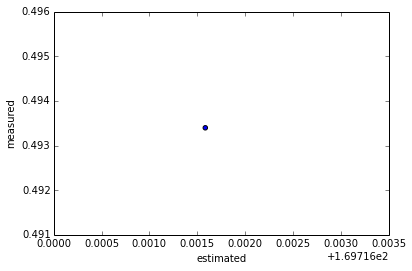

In [6]:
df = pd.DataFrame({'measured': measured_energy, 'estimated': est_energy}, columns=['measured', 'estimated'])
df.plot.scatter(x='estimated', y='measured')

In [7]:
tests

[<tests.eas.generic.OneSmallTask testMethod=runTest>]

## Show results

Now we'll plot:

- Task residency
- CPU frequency (if available)
- Energy recorded by energy meter (if available)
- Energy estimated:
  - By `sched_group_energy` in the kernel (using the `sched_energy_diff` trace event)
  - By `EnergyModel`, according to the ideal utilization values that would be expected for the observed task placement
  - By `EnergyMOdel`, according to the utilization values extracted via the `sched_load_avg_cpu` event

In [8]:
t = tests[0]
ex = t.executor.experiments[0]
trace = t.get_trace(ex)

Maximum estimated system energy: 1725


In [9]:
plot_trace(trace.ftrace)

In [10]:
df.head()

,measured,estimated
0,0.493397,169.717585


In [11]:
em = t.te.nrg_model

In [12]:
est_idle_df = em.mimic_sched_group_energy(trace, component='idle')
est_active_df = em.mimic_sched_group_energy(trace, component='active')

In [14]:
1 | 2

3

In [15]:
hex(3)

'0x3'

In [16]:
reduce(lambda x, y: x | y, (1, 2, 3, 4))

7

In [85]:
def get_estimations_df(test, component=None, column=None):
    # Get EnergyModel estimation of energy according to task placement (i.e. ignoring actual util values)
    placement_est = test.get_power_df(ex)['power']

    # Get energy estimated by scheduler's sched_group_energy (this is a trace event added by me)
    # To make this the most useful, hack the kernel so that it always computes energy for all sched_groups
    df = trace.ftrace.sg_energy.data_frame
    df = df.groupby(level=0).last() # drop rows with duplicate index to placate `pivot`
    sched_est = df.pivot(columns='sg_cpus')[['idle', 'active']].fillna(method='ffill')
    if component is None:
        sched_est = sched_est['idle'] + sched_est['active']
    else:    
        sched_est = sched_est[component]

    if column is None:
        sched_est = sched_est.sum(axis=1)
    else:
        cpus_string = hex(reduce(lambda x, y: x | (1 << y), column, 0))
        sched_est = sched_est[cpus_string]
        
    # Get detailed estimation according to EnergyModel
    model_est = test.te.nrg_model.mimic_sched_group_energy(trace, component=component,
                                                          sample_index=sched_est.index)
    if column is None:
        model_est = model_est.sum(axis=1)
    else:
        model_est = model_est[column]
    # model_est = model_est.reindex(sched_est.index, method='ffill')
    
    df = pd.concat([sched_est, model_est, placement_est], axis=1).fillna(method='ffill')

    #df = df.sort_index().fillna(method='ffill')
    df.columns = ['sched_group_energy', 'EnergyModel (sched_load_avg_task)', 'EnergyModel (placement)']
    
    return df

In [86]:
df = get_estimations_df(tests[0], component=None, column=None)
ILinePlot(df, column=['sched_group_energy', 'EnergyModel (sched_load_avg_task)'], 
          drawstyle='steps-after', title='Energy estimation comparison').view()

Maximum estimated system energy: 1725


""
""


In [56]:
def signal_value_at_time(signal, time):
    return signal.reindex([time], method='ffill').iloc[0]

In [67]:
freq = parser.solve('cpu_frequency:frequency')
idle = parser.solve('cpu_idle:state')
util = parser.solve('sched_load_avg_cpu:util_avg')
_inputs = pd.concat([freq, idle, util], axis=1,
                   keys=['freq', 'idle', 'util'])
inputs = _inputs.fillna(method='ffill').dropna().drop_duplicates()

In [76]:
signal_value_at_time(freq, 5.3)

0          NaN
1    1100000.0
2    1100000.0
3          NaN
4          NaN
5          NaN
Name: 5.3, dtype: float64

In [75]:
ILinePlot(freq, column=2).view()

""
""


In [77]:
t = 2.53
parser = Parser(trace.ftrace)
freq = parser.solve('cpu_frequency:frequency')
idle = parser.solve('cpu_idle:state')
util = parser.solve('sched_load_avg_cpu:util_avg')
_inputs = pd.concat([freq, idle, util], axis=1,
                   keys=['freq', 'idle', 'util'])
inputs = _inputs.fillna(method='ffill').drop_duplicates()
df = get_estimations_df(tests[0], component='idle', column=(2,))

print "inputs:"
print signal_value_at_time(inputs, t)

print "\n"
idle_idxs = [int(i) for i in signal_value_at_time(idle, t)]
print idle_idxs
idle_states = [n.idle_state_by_idx(i) for i, n in zip(idle_idxs, em.cpu_nodes)]
print idle_states
print em.estimate_from_cpu_util([int(u) for u in signal_value_at_time(util, t)],
                               idle_states=idle_states, combine=False)[2,]
print "\n"
print "sched:"
print signal_value_at_time(df['sched_group_energy'], t)

print "\n"
print "mimiced:"
print signal_value_at_time(df['EnergyModel (sched_load_avg_task)'], t)

Maximum estimated system energy: 1725
inputs:
freq  0     NaN
      1     NaN
      2     NaN
      3     NaN
      4     NaN
      5     NaN
idle  0     1.0
      1     1.0
      2     1.0
      3     2.0
      4     2.0
      5     1.0
util  0    17.0
      1    25.0
      2    12.0
      3    18.0
      4    30.0
      5    19.0
Name: 2.53, dtype: float64


[1, 1, 1, 2, 2, 1]
['cpu-sleep-0', 'cpu-sleep-0', 'cpu-sleep-0', 'cluster-sleep-0', 'cluster-sleep-0', 'cpu-sleep-0']
{'active': 4.83453237410072, 'idle': 0.0}


sched:
0.0


mimiced:
14.2446043165


In [48]:
em.cpu_nodes[0].

[EnergyModelNode(cpus=[0]),
 EnergyModelNode(name="cpu1", cpus=[1]),
 EnergyModelNode(name="cpu2", cpus=[2]),
 EnergyModelNode(name="cpu3", cpus=[3]),
 EnergyModelNode(name="cpu4", cpus=[4]),
 EnergyModelNode(name="cpu5", cpus=[5])]

In [45]:
[n.idle_state_by_idx(0) for n in em.cpu_nodes]

['WFI', 'WFI', 'WFI', 'WFI', 'WFI', 'WFI']

In [21]:
# Helper to conver an int into a list of the bits set in it
def to_bits(n):
    ret = []
    for i in range(6):
        if n % 2:
            ret += [i]
        n /= 2
    return tuple(ret)

# Take a DataFrame with columns like ['0x1', '0x2', '0x4', '0x6']
# Return one with columns like       [(0,),  (1,),  (2,),  (1, 2)]
# i.e. convert columns from hex strings representing cpumasks to tuples with logical CPU numbers.
def fix_cols(df):
    df = pd.DataFrame(df)
    df.columns = [to_bits(int(col, 0)) for col in df.columns]
    return df

sched_idle_df = fix_cols(df['idle']).fillna(method='ffill')
sched_active_df = fix_cols(df['active']).fillna(method='ffill')

def examine(test, experiment_idx=0, plot_residency=True, plot_freqs=True):
    ex = test.executor.experiments[experiment_idx]
    
    # Show task residency
    trace = test.get_trace(ex)
    if plot_freqs:
        plot_trace(trace.ftrace)
    
    if plot_freqs and 'cpu_frequency' in trace.available_events:
        p = Parser(trace.ftrace)
        freq_df = p.solve('cpu_frequency:frequency')
        ILinePlot(freq_df, drawstyle='steps-post', title="CPU Frequency").view()
    
    csv_path = os.path.join(ex.out_dir, "samples_Device0.csv")
    if os.path.exists(csv_path):
        # Show recorded energy
        samples_df = pd.read_csv(csv_path, sep=", ", engine='python', index_col='"timestamp ms"')
        samples_df.index.name='time'
        samples_df.index /= 1000
        samples_df = samples_df[['"power mW"']]
        samples_df.columns = ['power']
        ILinePlot(samples_df, column='power', title="Recorded energy").view()

    print "ESTIMATED ENERGY:"
    df = get_estimations_df(trace)

    display(df.corr())
    ILinePlot(df, column=df.columns.tolist(), 
              drawstyle='steps-after', title='Energy estimation comparison').view()
    
df = examine(tests[0], plot_freqs=False, plot_residency=False)

KeyError: 'idle'

In [ ]:
df.corr()